# Data Analysis Interview Challenge

## Exploratory Data Analysis
The **`logins.json`** file contains (simulated) timestamps of user logins in a particular geographical location.
* Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 
* Report/illustrate important features of the demand, such as daily cycles. 
* Report any data quality issues. 

In [36]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics


import calendar
from ast import literal_eval
import json
from datetime import datetime

In [2]:
# read in the json file
df_logins = pd.read_json('logins.json')

#check dtype and look for NaN's
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [3]:
#take a look at the dataframe
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df_logins.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


Incomplete data for April

In [5]:
#create count col to track num of logins
df_logins['login_count']=1

#make login_time the index for easier aggregration
df_logins = df_logins.set_index('login_time')

# take a look
df_logins.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


### Aggregate login counts based on 15 minute time intervals

In [6]:
# resample in 15 min intervals and sum
df_logins_15 = df_logins.resample('15Min').sum()
df_logins_15.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


C:\Users\sixsi\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


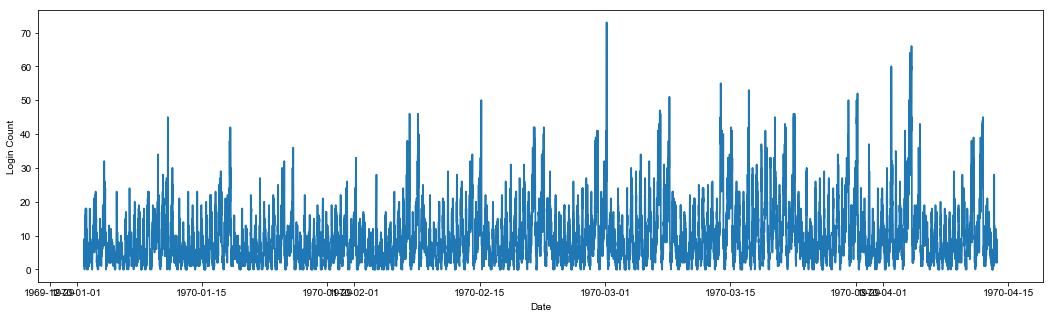

In [7]:
# Take a quick look
plt.figure(figsize=(18, 5))
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Login Count')
plt.style.use('seaborn')

plt.plot(df_logins_15.index, df_logins_15['login_count'])
plt.show()

Some periodicity is evident, we need to parse the data into larger timeframes

In [8]:
# copy and create new df
df_groups = df_logins_15.copy()
df_groups.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [9]:
df_groups['time'] = df_groups.index

# create new col for hour, weekday, and month
df_groups['hour'] = df_groups['time'].dt.hour
df_groups['weekday'] = df_groups['time'].dt.weekday
df_groups['month'] = df_groups['time'].dt.month

In [10]:
df_groups.head()

,login_count,time,hour,weekday,month
login_time,,,,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00,20,3,1
1970-01-01 20:15:00,6,1970-01-01 20:15:00,20,3,1
1970-01-01 20:30:00,9,1970-01-01 20:30:00,20,3,1
1970-01-01 20:45:00,7,1970-01-01 20:45:00,20,3,1
1970-01-01 21:00:00,1,1970-01-01 21:00:00,21,3,1


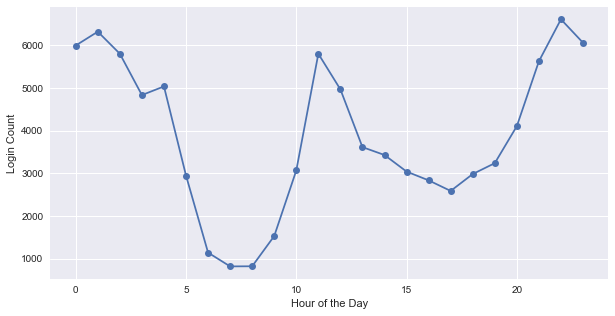

In [11]:
# create hour group
hour_df = df_groups.groupby('hour')['login_count'].sum()

# plot
plt.figure(figsize=(10, 5))
plt.tight_layout()
plt.xlabel('Hour of the Day')
plt.ylabel('Login Count')
plt.style.use('seaborn')

plt.plot(hour_df.index, hour_df.values, marker='o')
plt.show()

Definite peaks at midday and late night - early morning

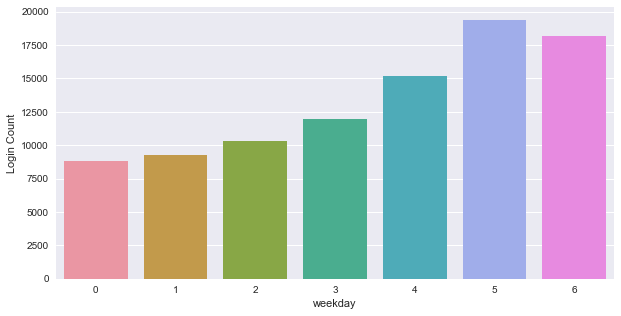

In [12]:
# create weekday group
weekday_df = df_groups.groupby('weekday')['login_count'].sum()

# plot
plt.figure(figsize=(10, 5))
plt.tight_layout()
plt.xlabel('Day of the Week')
plt.ylabel('Login Count')

sns.barplot(weekday_df.index, weekday_df.values)
plt.show()

With 0 = Sunday, There is a increase in logins throughout the week

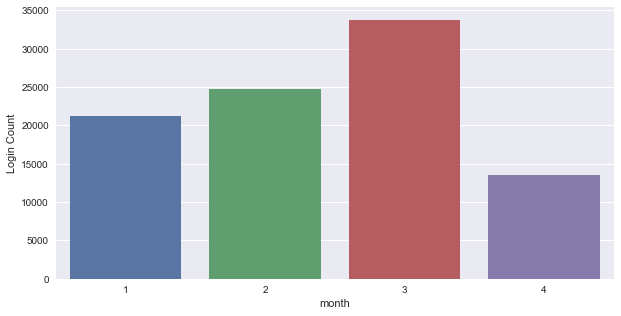

In [13]:
# create weekday group
month_df = df_groups.groupby('month')['login_count'].sum()

# plot
plt.figure(figsize=(10, 5))
plt.tight_layout()
plt.xlabel('Month')
plt.ylabel('Login Count')

sns.barplot(month_df.index, month_df.values)
plt.show()

Logins peak in March. However, there is incomplete data for April so we are unable to draw conclusions from the Monthly aggregration

## Part 2 - Experiment and Metrics Design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. 

On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. 

The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. **What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric.**

First I would answer their question, are driver partners available in both cities following the change. I assume I would have access to data from the toll bridge indicating the number of crossings. In order for an apples to apples comparison, the metric of choice would be daily crossings divided by the number of drivers that particular day. This normalizes the number of crossings so that the number of drivers does not skew the results.

2. **Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.**

    a. Essentially we would be comparing two time periods, before and after the policy change. I would attempt to have a relatively balanced dataset, equal numbers of before and after points.
    
    b. This is a perfect application for ANOVA. Ha: the number of crossings per day per driver before the policy change is equal to the number of crossings per day per driver after the change. 
    
    c. Assuming alpha = 0.05, a p-value of < 0.05 would cause us to reject the null hypothesis and state the policy change had an effect on the number of driver crossings
    
This would just be the first step and it would tell you if the policy influenced driver behavior. The next step would be to compare profitability before and after the change. For example, if the program was a success and drivers were serving both cities but they lost money because of the increased cost or other factors...abandon this program and try another!

## Part 3 - Predictive Modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were active (took a trip) in the preceding 30 days.

We would like to use this data to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

### Data Description
* city : city this user signed up in
* phone : primary device for this user
* signup_date: date of account registration, in the form YYYYMMDD
* last_trip_date : the last date this user completed a trip YYYYMMDD
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver : the rider's average rating over all of their trips
* avg_rating_of_driver : the rider's average rating of their drivers over all of their trips
* surge_pct : the percent of trips taken with surge multiplier > 1
* avg_surge: the average surge multiplier over all of this user's trips
* trips_in_first_30_days : the number of trips thi suser took in the first 30 days after signup
* ultimate_black_user : TRUE if the user took an Utlimate Black in their first 30 days; FALSE otherwise.
* weekday_pct : the percent of the user's trips occuring during a weekday.

In [14]:
# read in the json file
data = open('ultimate_data_challenge.json', 'r').readline()
data = json.loads(data)

df = pd.DataFrame(data)
df.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [15]:
#check dtype and look for NaN's
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


avg rating, by and of the driver along with phone have null values

last_trip_date and signup_date are objects and need to be converted to dates

In [16]:
# date conversions
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

print(df['last_trip_date'].dtype)
print(df['signup_date'].dtype)

datetime64[ns]
datetime64[ns]


In [17]:
# distribution of ratings
print(df['avg_rating_by_driver'].value_counts())
print(df['avg_rating_of_driver'].value_counts())

5.0    28508
4.8     4537
4.7     3330
4.9     3094
4.5     2424
4.6     2078
4.0     1914
4.3     1018
4.4      860
3.0      602
4.2      342
3.5      199
3.7      195
1.0      181
2.0      126
4.1      125
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
3.2        2
2.7        2
2.3        1
Name: avg_rating_by_driver, dtype: int64
5.0    20771
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.8        2
1.7        2
2.2        1
1.6        1
1.9        1
Name: avg_rating_of_driver, dtype: int64


Both ratings are heavily right skewed and will not contribute much to the model

In [18]:
# remove ratings col
df = df.drop('avg_rating_of_driver', axis=1)
df = df.drop('avg_rating_by_driver', axis=1)
df.columns

Index(['avg_dist', 'avg_surge', 'city', 'last_trip_date', 'phone',
       'signup_date', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct'],
      dtype='object')

In [19]:
# look at the phone distribution
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

We'll just assume that a missing phone is an iPhone


In [20]:
df['phone'] = df['phone'].fillna('iPhone')

In [21]:
# one more look at the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
avg_dist                  50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(4), int64(1), object(2)
memory usage: 3.5+ MB


In [22]:
# verify signup dates are from january
print(df['signup_date'].min())
print(df['signup_date'].max())

2014-01-01 00:00:00
2014-01-31 00:00:00


In [23]:
# find the last date of last trip date
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [24]:
# create a retained column
df['retained'] = df['last_trip_date'].apply(lambda x: 1 if x >= pd.to_datetime('2014-06-01') else 0)
# look at distribution
df['retained'].value_counts()

0    31196
1    18804
Name: retained, dtype: int64

In [25]:
round(df['retained'].value_counts(1)[1]*100, 2)

37.61

Data Suggests ~38% of users are retained

In [26]:
# Remove date cols from the df, no longer needed for modeling
df = df.drop(['signup_date', 'last_trip_date'], axis=1)
df.head()

,avg_dist,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,1.10,King's Landing,iPhone,15.4,4,True,46.2,1
1,8.26,1.00,Astapor,Android,0.0,0,False,50.0,0
2,0.77,1.00,Astapor,iPhone,0.0,3,False,100.0,0
3,2.36,1.14,King's Landing,iPhone,20.0,9,True,80.0,1
4,3.13,1.19,Winterfell,Android,11.8,14,False,82.4,0


In [27]:
# change boolean to 0 and 1
df['ultimate_black_user'] =  df['ultimate_black_user'].apply(lambda x: 1 if x else 0)
df.head()

,avg_dist,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,1.10,King's Landing,iPhone,15.4,4,1,46.2,1
1,8.26,1.00,Astapor,Android,0.0,0,0,50.0,0
2,0.77,1.00,Astapor,iPhone,0.0,3,0,100.0,0
3,2.36,1.14,King's Landing,iPhone,20.0,9,1,80.0,1
4,3.13,1.19,Winterfell,Android,11.8,14,0,82.4,0


In [28]:
# Create dummy variables for object cols
df = pd.get_dummies(df, columns=['city', 'phone'])
df.head()

,avg_dist,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,1.10,15.4,4,1,46.2,1,0,1,0,0,1
1,8.26,1.00,0.0,0,0,50.0,0,1,0,0,1,0
2,0.77,1.00,0.0,3,0,100.0,0,1,0,0,0,1
3,2.36,1.14,20.0,9,1,80.0,1,0,1,0,0,1
4,3.13,1.19,11.8,14,0,82.4,0,0,0,1,1,0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_surge                 50000 non-null float64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
city_Astapor              50000 non-null uint8
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_Android             50000 non-null uint8
phone_iPhone              50000 non-null uint8
dtypes: float64(4), int64(3), uint8(5)
memory usage: 2.9 MB


## Build a predictive model

In [30]:
# Separate into target and predictor variables
X = df.drop('retained', axis=1)
y = df['retained']

In [31]:
# create test and training datasets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 69, stratify = y)

### Simple Linear Regression

In [32]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\sixsi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
y_pred = model.predict(X_test)

# print training and test accuracies
print('Accuracy on the training data = ', model.score(X_train, y_train))
print('Accuracy on the test data = ', model.score(X_test, y_test))

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on the training data =  0.7166
Accuracy on the test data =  0.714
[[5310  929]
 [1931 1830]]
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      6239
           1       0.66      0.49      0.56      3761

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.70      0.67      0.67     10000
weighted avg       0.71      0.71      0.70     10000



In [53]:
# Logistic Regression feature importance
pd.Series(model.coef_.reshape(-1), index=X.columns)


avg_dist                 -0.035315
avg_surge                -0.160637
surge_pct                 0.003714
trips_in_first_30_days    0.123654
ultimate_black_user       0.870590
weekday_pct              -0.000145
city_Astapor             -0.905372
city_King's Landing       0.788523
city_Winterfell          -0.380574
phone_Android            -0.780465
phone_iPhone              0.283042
dtype: float64

Most Important features are City_Astapor andUltimate Black User

## Random Forest Classifier

In [38]:
rf =RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\sixsi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
rf_y_pred = rf.predict(X_test)

# print training and test accuracies
print('Accuracy on the training data = ', rf.score(X_train, y_train))
print('Accuracy on the test data = ', rf.score(X_test, y_test))

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

Accuracy on the training data =  0.964725
Accuracy on the test data =  0.7328
[[5067 1172]
 [1500 2261]]
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      6239
           1       0.66      0.60      0.63      3761

   micro avg       0.73      0.73      0.73     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.73      0.73      0.73     10000



without hypertuning parameters, slight improvement with random forests, **73.3%** vs logistic regression

It must be noted too that the random forest model is overfitting on the training data

In [56]:
# random forest feature importance
pd.Series(rf.feature_importances_.reshape(-1), index = X.columns)

avg_dist                  0.412689
avg_surge                 0.071808
surge_pct                 0.121801
trips_in_first_30_days    0.083224
ultimate_black_user       0.030399
weekday_pct               0.176406
city_Astapor              0.015827
city_King's Landing       0.040480
city_Winterfell           0.010608
phone_Android             0.019972
phone_iPhone              0.016785
dtype: float64

With Random Forests, Avg_dist and weekday_pct are the most important features

## Takeaways for Ultimate

1. In order to make the best decisions, the Logistic Regression and Random Forest models should have their hyperparameters tuned. Additionally, if time permitted, it would'nt hurt to run gradient boosting classifer or XGBoost classifiers. Then whichever model had the best performance, go with it.

2. With regard to the Random Forest model, the average distance travelled in the first 30 days, and the percentage of the users trips that was the most important feature. definitely work on incentives to reward this behavior.

A point about the dataset. I do not necessarily think behaviors in the first 30 days may best describe a decision, whether to continue to use the service, six month down the road. For instance why would the length of trips taken in the first 30 days be a better predictor than those taken over the entire time period? Or wouldn't it be important to know is a user took an Ultimate Black after their first 30 days?